In [1]:
import pandas as pd
pd.options.display.max_columns = None
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from xgboost import XGBClassifier
import mlflow
import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
version = "v1.0"
data_url = "../data/fraud.csv"

In [3]:
import sys  
sys.path.insert(0, '../backend/src')

import data_preprocessing_training

In [4]:
from data_preprocessing_training import transform_data

In [5]:
"""
os.environ['MLFLOW_TRACKING_USERNAME']= "..."
os.environ["MLFLOW_TRACKING_PASSWORD"] = "..."
"""

'\nos.environ[\'MLFLOW_TRACKING_USERNAME\']= "..."\nos.environ["MLFLOW_TRACKING_PASSWORD"] = "..."\n'

In [5]:

from dotenv import load_dotenv
import os
load_dotenv("../backend/src/.env")

DagsHub_username = os.getenv("DagsHub_username")
DagsHub_token=os.getenv("DagsHub_token")


In [6]:

import os
os.environ['MLFLOW_TRACKING_USERNAME']= DagsHub_username
os.environ["MLFLOW_TRACKING_PASSWORD"] = DagsHub_token


In [7]:

#setup mlflow
mlflow.set_tracking_uri('https://dagshub.com/bbhamed/mlops.mlflow') #your mlfow tracking uri
mlflow.set_experiment("fraud-detector-experiment")



2024/05/29 09:20:55 INFO mlflow.tracking.fluent: Experiment with name 'fraud-detector-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/b26c3925d9344fc1958b2572d31493fa', creation_time=1716970855752, experiment_id='0', last_update_time=1716970855752, lifecycle_stage='active', name='fraud-detector-experiment', tags={}>

In [8]:
#read the data
df = pd.read_csv(data_url)

In [9]:
#shape of the data
df.shape

(100000, 23)

In [10]:
#cleaning and preprocessing
X_train,X_test,y_train,y_test = transform_data(df)

In [11]:
X_train.head()

,amt,gender,zip,lat,long,merch_lat,merch_long,year,month,day,hour,minute,sec,age,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
78689,98.21,1,33956,26.5290,-82.0916,26.755882,-82.439298,2019,2,16,12,56,20,48,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76423,6.01,1,29860,33.6028,-81.9748,32.867139,-82.648669,2019,2,14,19,23,59,82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
86945,2.62,1,46290,39.9347,-86.1633,38.937676,-85.222318,2019,2,20,17,13,19,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
57427,6.85,0,13755,42.0716,-75.0152,42.047015,-75.653525,2019,2,3,23,22,35,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
34616,45.48,1,67232,37.6395,-97.1714,38.460762,-96.496218,2019,1,21,12,31,18,39,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
X_train.columns

Index(['amt', 'gender', 'zip', 'lat', 'long', 'merch_lat', 'merch_long',
       'year', 'month', 'day', 'hour', 'minute', 'sec', 'age',
       'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel'],
      dtype='object')

# Resolve imbalanced data problem:

**Before moving forward to Machine Learning modeling , we need to handle the problem of unbalanced data, this is very common with fraud data, there is always the issue of class imbalance where actual fraud cases are way fewer than normal cases and constitute only a very small part of the dataset.**

**For this purpose we will be using SMOTE(Synthetic Minority Oversampling Technique) which is a statistical technique for increasing the number of cases in your dataset in a balanced way. The component works by generating new instances from existing minority cases that you supply as input. This implementation of SMOTE does not change the number of majority cases.**

**The new instances are not just copies of existing minority cases. Instead, the algorithm takes samples of the feature space for each target class and its nearest neighbors. The algorithm then generates new examples that combine features of the target case with features of its neighbors. This approach increases the features available to each class and makes the samples more general.**

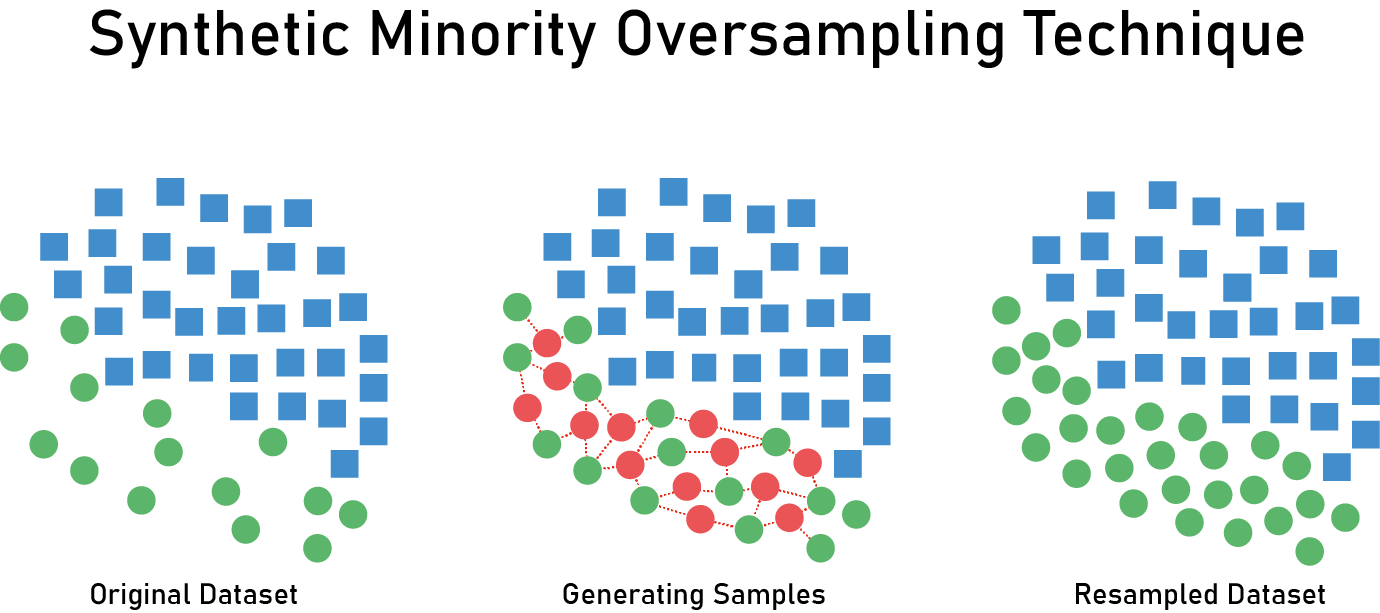

In [13]:
from IPython.display import Image
Image(filename="images/smote.png")

In [14]:
method= SMOTE()
X_resampled, y_resampled = method.fit_resample(X_train, y_train)

# 2. Machine Learning Modeling :

## 1. Logistic Regression :
Logistic Regression : It is used in classification use cases where we
want to predict a discrete target ( for example whether something is true
or false). It catches the relationship between the target variable ( class
column in our case ) and the independant features ( clump thickness ,
sizeUniformity .. ) by fitting our data with the Sigmoid function.

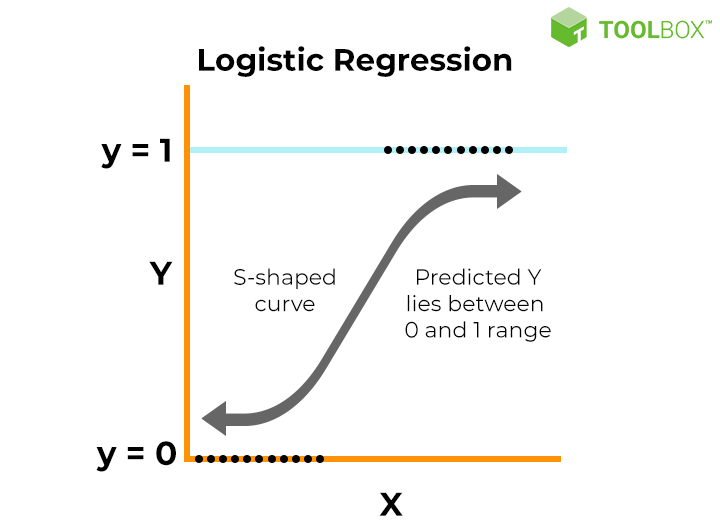

In [15]:
Image(filename="images/lg.png")

In [16]:

mlflow.sklearn.autolog(disable=True)


In [17]:

with mlflow.start_run(run_name='LogisticRegression'):
    mlflow.log_param("data_url",data_url)
    mlflow.log_param("data_version",version)
    mlflow.log_param("input_rows",df.shape[0])
    mlflow.log_param("input_cols",df.shape[1])
    #model fitting and training
    lr=LogisticRegression()
    mlflow.set_tag(key= "model",value="LogisticRegression")
    params = lr.get_params()
    mlflow.log_params(params)
    lr.fit(X_resampled,y_resampled)
    train_features_name = f'{X_resampled=}'.split('=')[0]
    train_label_name = f'{y_resampled=}'.split('=')[0]
    mlflow.set_tag(key="train_features_name",value= train_features_name)
    mlflow.set_tag(key= "train_label_name",value=train_label_name)
    predicted=lr.predict(X_test)
    precision,recall,fscore,support=score(y_test,predicted,average='macro')
    mlflow.log_metric("Precision_test",precision)
    mlflow.log_metric("Recall_test",recall)
    mlflow.log_metric("F1_score_test",fscore)
    mlflow.sklearn.log_model(lr,artifact_path="ML_models")


In [18]:
lr=LogisticRegression()
lr.fit(X_resampled,y_resampled)
predicted=lr.predict(X_test)

## Model evaluation :
### Evaluation metrics:
* **Precision:** 
Precision is one indicator of the quality of the positive predictions
made by the model. **Of all the positive predictions I made, how many of them are truly positive?** \
Precision is defined as follows:

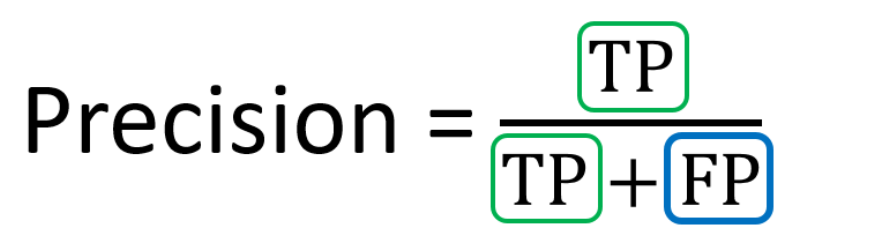

In [19]:
Image(filename="images/Precision.png")

**Remark:**
 * A true positive (TP) is an outcome where the model correctly
predicts the positive class. Similarly, a true negative (TN) is
an outcome where the model correctly predicts the negative class.
 * A false positive (FP) is an outcome where the model incorrectly
predicts the positive class. And a false negative (FN) is an
outcome where the model incorrectly predicts the negative class.

* **Recall:**
Recall, a commonly used performance metric for classification models,
is the fraction of positives that are correctly classified,**Of all the actual positive examples out there, how many of them did I correctly predict to be positive?**

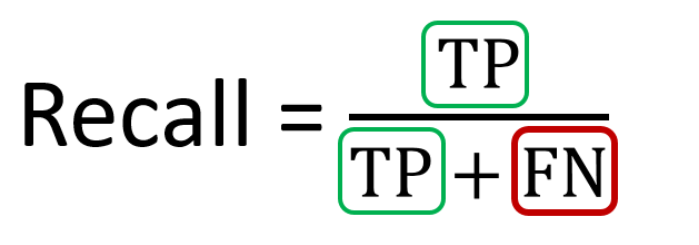

In [20]:
Image(filename="images/Recall.png")

* **F1-score:** To evaluate model performance comprehensively, we should examine both precision and recall. The F1 score serves as a helpful metric that considers both of them.

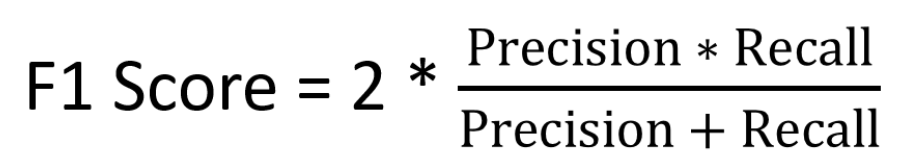

In [21]:
Image(filename="images/F1_score.png")

* **Accuracy:**
    Accuracy is the number of correctly predicted data points out of all the data points.

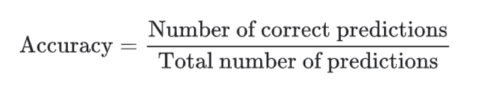

In [22]:
Image(filename="images/accuracy.png")

**To evaluate fraud detection models, the concepts of recall and precision are very important.Recall  meaures how many fraud cases where trully detected while precision evaluates how good the model is at generating as fewer false alarms as possible. For fraud detection, we want to prioritize high recall to leave out as few fraud cases as possible while also having a relatively high precision because too many false alarms can also be a problem!**

In [23]:
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     19809
           1       0.12      0.77      0.20       191

    accuracy                           0.94     20000
   macro avg       0.56      0.86      0.59     20000
weighted avg       0.99      0.94      0.96     20000

Confusion matrix:
 [[18703  1106]
 [   44   147]]
Share of Non-Fraud in Test Data: 0.9904


**As we can see above the recall is around 77% while precision is just 12% which means there is a lot of false positives to handle.**

## 2. Random forest:

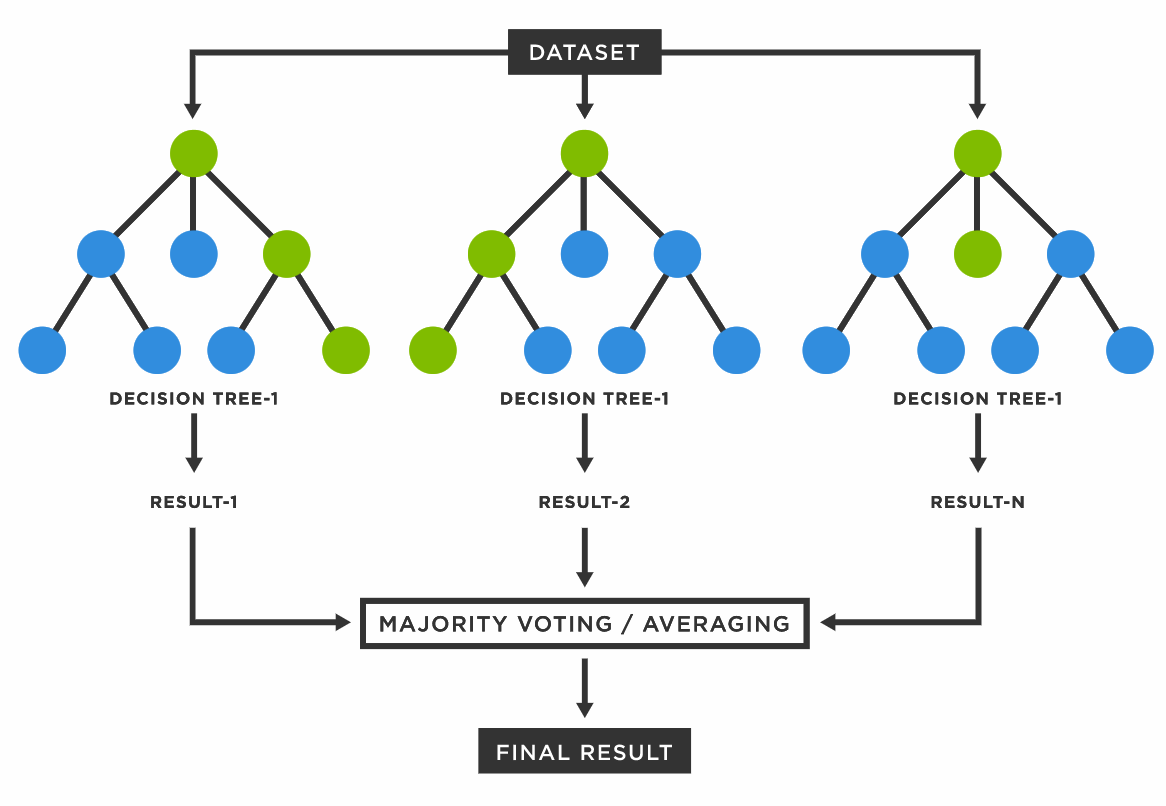

In [24]:
Image(filename="images/random.png")

In [25]:

mlflow.sklearn.autolog(disable=True)


In [26]:

with mlflow.start_run(run_name='RandomForest'):
    mlflow.log_param("data_url",data_url)
    mlflow.log_param("data_version",version)
    mlflow.log_param("input_rows",df.shape[0])
    mlflow.log_param("input_cols",df.shape[1])
    rf = RandomForestClassifier(random_state=5)
    mlflow.set_tag(key="model", value = "RandomForest")
    params = rf.get_params()
    mlflow.log_params(params)
    rf.fit(X_resampled,y_resampled)
    train_features_name = f'{X_resampled=}'.split('=')[0]
    train_label_name = f'{y_resampled=}'.split('=')[0]
    mlflow.set_tag(key="train_features_name",value= train_features_name)
    mlflow.set_tag(key= "train_label_name",value=train_label_name)
    predicted=rf.predict(X_test)
    precision,recall,fscore,support=score(y_test,predicted,average='macro')
    mlflow.log_metric("Precision_test",precision)
    mlflow.log_metric("Recall_test",recall)
    mlflow.log_metric("F1_score_test",fscore)
    mlflow.sklearn.log_model(rf,artifact_path="ML_models")


In [27]:
rf = RandomForestClassifier(random_state=5)
rf.fit(X_resampled,y_resampled)
predicted=rf.predict(X_test)

In [28]:
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19809
           1       0.88      0.79      0.83       191

    accuracy                           1.00     20000
   macro avg       0.94      0.89      0.91     20000
weighted avg       1.00      1.00      1.00     20000

Confusion matrix:
 [[19788    21]
 [   41   150]]
Share of Non-Fraud in Test Data: 0.9904


**The above metrics show that although the Random Forest model has a slightly lower recall, it has much better precision!**

## 3.Xgboost:

In [29]:

mlflow.xgboost.autolog(disable=True)


In [30]:

with mlflow.start_run(run_name='XGBoost'):
    mlflow.log_param("data_url",data_url)
    mlflow.log_param("data_version",version)
    mlflow.log_param("input_rows",df.shape[0])
    mlflow.log_param("input_cols",df.shape[1])
    xg = XGBClassifier()
    params = xg.get_params()
    mlflow.set_tag(key= "model", value="XGBClassifier")
    mlflow.log_params(params)
    xg.fit(X_train,y_train)
    train_features_name = f'{X_train=}'.split('=')[0]
    train_label_name = f'{y_train=}'.split('=')[0]
    mlflow.set_tag(key="train_features_name",value= train_features_name)
    mlflow.set_tag(key= "train_label_name",value=train_label_name)
    predicted=xg.predict(X_test)
    precision,recall,fscore,support=score(y_test,predicted,average='macro')
    mlflow.log_metric("Precision_test",precision)
    mlflow.log_metric("Recall_test",recall)
    mlflow.log_metric("F1_score_test",fscore)
    mlflow.xgboost.log_model(xg,artifact_path="ML_models")


In [31]:
xg = XGBClassifier()
xg.fit(X_train,y_train)
predicted=xg.predict(X_test)

In [32]:
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19809
           1       0.96      0.86      0.91       191

    accuracy                           1.00     20000
   macro avg       0.98      0.93      0.95     20000
weighted avg       1.00      1.00      1.00     20000

Confusion matrix:
 [[19803     6]
 [   27   164]]
Share of Non-Fraud in Test Data: 0.9904


In [33]:

#Reading Pandas Dataframe from mlflow
all_experiments = [exp.experiment_id for exp in mlflow.search_experiments()]
df_mlflow = mlflow.search_runs(experiment_ids=all_experiments,filter_string="metrics.F1_score_test <1")
run_id = df_mlflow.loc[df_mlflow['metrics.F1_score_test'].idxmax()]['run_id']


In [34]:

df_mlflow


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.F1_score_test,metrics.Recall_test,metrics.Precision_test,params.eval_metric,params.colsample_bylevel,params.importance_type,params.device,params.subsample,params.input_rows,params.early_stopping_rounds,params.callbacks,params.max_delta_step,params.booster,params.feature_types,params.max_bin,params.scale_pos_weight,params.enable_categorical,params.data_url,params.n_estimators,params.validate_parameters,params.max_cat_threshold,params.colsample_bynode,params.min_child_weight,params.random_state,params.learning_rate,params.multi_strategy,params.reg_lambda,params.objective,params.tree_method,params.max_cat_to_onehot,params.missing,params.data_version,params.max_leaves,params.gamma,params.colsample_bytree,params.grow_policy,params.max_depth,params.sampling_method,params.verbosity,params.interaction_constraints,params.num_parallel_tree,params.n_jobs,params.reg_alpha,params.base_score,params.input_cols,params.monotone_constraints,params.ccp_alpha,params.max_features,params.criterion,params.min_samples_split,params.bootstrap,params.min_samples_leaf,params.warm_start,params.max_samples,params.class_weight,params.verbose,params.min_weight_fraction_leaf,params.oob_score,params.max_leaf_nodes,params.min_impurity_decrease,params.multi_class,params.intercept_scaling,params.fit_intercept,params.penalty,params.max_iter,params.C,params.dual,params.tol,params.solver,params.l1_ratio,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.log-model.history,tags.mlflow.user,tags.train_label_name,tags.mlflow.runName,tags.model,tags.train_features_name
0,e14ad66e453643a780dee296c0ae421c,0,FINISHED,mlflow-artifacts:/b26c3925d9344fc1958b2572d314...,2024-05-29 08:24:13.644000+00:00,2024-05-29 08:24:26.114000+00:00,0.953877,0.929168,0.981672,None,None,None,None,None,100000,None,None,None,None,None,None,None,False,../data/fraud.csv,None,None,None,None,None,None,None,None,None,binary:logistic,None,None,nan,v1.0,None,None,None,None,None,None,None,None,None,None,None,None,23,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,/opt/anaconda3/envs/mlops/lib/python3.10/site-...,LOCAL,"[{""run_id"": ""e14ad66e453643a780dee296c0ae421c""...",bbhamed,y_train,XGBoost,XGBClassifier,X_train
1,0eda3887e9d74cfc9a1fe228f1033307,0,FINISHED,mlflow-artifacts:/b26c3925d9344fc1958b2572d314...,2024-05-29 08:22:50.456000+00:00,2024-05-29 08:23:26.504000+00:00,0.913583,0.892140,0.937563,None,None,None,None,None,100000,None,None,None,None,None,None,None,None,../data/fraud.csv,100,None,None,None,None,5,None,None,None,None,None,None,None,v1.0,None,None,None,None,None,None,None,None,None,None,None,None,23,None,0.0,sqrt,gini,2,True,1,False,None,None,0,0.0,False,None,0.0,None,None,None,None,None,None,None,None,None,None,/opt/anaconda3/envs/mlops/lib/python3.10/site-...,LOCAL,"[{""run_id"": ""0eda3887e9d74cfc9a1fe228f1033307""...",bbhamed,y_resampled,RandomForest,RandomForest,X_resampled
2,09de69171f204dca9b085398ce0c3e72,0,FINISHED,mlflow-artifacts:/b26c3925d9344fc1958b2572d314...,2024-05-29 08:21:51.471000+00:00,2024-05-29 08:22:07.279000+00:00,0.586887,0.856900,0.557486,None,None,None,None,None,100000,None,None,None,None,None,None,None,None,../data/fraud.csv,None,None,None,None,None,None,None,None,None,None,None,None,None,v1.0,None,None,None,None,None,None,None,None,None,None,None,None,23,None,None,None,None,None,None,None,False,None,None,0,None,None,None,None,auto,1,True,l2,100,1.0,False,0.0001,lbfgs,None,/opt/anaconda3/envs/mlops/lib/python3.10/site-...,LOCAL,"[{""run_id"": ""09de69171f204dca9b085398ce0c3e72""...",bbhamed,y_resampled,LogisticRegression,LogisticRegression,X_resampled


In [35]:

run_id


'e14ad66e453643a780dee296c0ae421c'

In [36]:

#let's call the model from the model registry ( in production stage)
import mlflow.pyfunc

logged_model = f'runs:/{run_id}/ML_models'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
print(loaded_model)

# Predict on a Pandas DataFrame.

loaded_model.predict(X_test)


mlflow.pyfunc.loaded_model:
  artifact_path: ML_models
  flavor: mlflow.xgboost
  run_id: e14ad66e453643a780dee296c0ae421c



array([0, 0, 0, ..., 0, 0, 0])